hotel booking demand
====================
#### https://www.kaggle.com/jessemostipak/hotel-booking-demand   
   
+ Find a problem
+ Analyze previous approaches
+ Modeling your methodolody
+ Analyzing data
+ Visualization
+ Collaborative Evaluation  
<br/>



</br>

-----------------

In [133]:
!pip install pycountry
!pip install catboost
!pip install xgboost
!pip install eli5
!pip install pdpbox
!pip install category_encoders

-----------
## 1. Packages Import


In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from pdpbox import pdp
pd.options.display.max_columns = None

In [135]:
## 데이터 불러오기
data = pd.read_csv('./hotel_bookings.csv')

In [136]:
## 데이터 확인
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


<br/></br>


--------------
## 2. Data Pre-Processing

In [137]:
## 전처리를 위한 데이터 복사
df = data.copy()

In [138]:
## column의 null 수 확인
df.isnull().sum().sort_values(ascending=False)[:10]

company                     112593
agent                        16340
country                        488
children                         4
lead_time                        0
arrival_date_year                0
arrival_date_month               0
arrival_date_week_number         0
is_canceled                      0
market_segment                   0
dtype: int64

<br/></br>

### 2-1) 위 결과를 토대로 company, agent , country, children  column 에 결측치 처리가 필요

In [139]:
## agent, company column의 값이 null 이면 0으로 대체한다.
df[['agent','company']] = df[['agent','company']].fillna(0.0)

## country column의 값이 null 이면 가장 많이 나온 값으로 대체한다.
df['country'].fillna(data.country.mode().to_string(), inplace=True)

In [140]:
## children column 값이 null 이면 0으로 대체한다.
df['children']=df['children'].fillna(0.0)

## adult, baby , child 합이 0인 row를 drop한다.
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

In [141]:
## datatype을 int로 바꾼다
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

<br/></br>

### 2-2) 숙박 일수에 대한 전처리 필요
+ 총 숙박 일수 1박 미만, 무료로 호텔을 이용한 경우 : 이상치로 판단

In [142]:
## 총 숙박 일수가 1박 미만인 row를 제거한다.

## 총 숙박 일수 feature
df['total_staying_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df = df[ df['total_staying_nights'] >= 1 ]
df = df.reset_index(drop=True)

In [143]:
## 값을 내고 호텔을 이용한 경우만 data로 사용한다.
df = df[ df['adr'] > 0 ].copy()

<br/></br>

### 2-3) feature 생성

In [144]:
## 새로운 feature를 위해 데이터 복사
df_subset = df.copy()

In [145]:
## reservation_status column은 y값으로 쓸 is_canceled와 같은 값이니 제거
df_subset = df_subset.drop(['reservation_status'], axis=1)

## Room column 새로 추가.
## 예약된 방과 같으면 1, 아니면 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1

## more canceled column 새로 추가.
## 예약 취소 비율이 높은 경우 1 , 아니면 0
df_subset['more_canceled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'not_canceled'] = 1

## reservation_status_date column 문자열 값을 year/month/date 값으로 분리
df_subset['reservation_status_date'] = pd.to_datetime(df_subset['reservation_status_date'])

df_subset['reservation_year'] = df_subset['reservation_status_date'].dt.year
df_subset['reservation_month'] = df_subset['reservation_status_date'].dt.month
df_subset['reservation_day'] = df_subset['reservation_status_date'].dt.day

## 남겨진 column 제거
df_subset = df_subset.drop(['booking_changes','assigned_room_type','reservation_status_date','distribution_channel'],axis=1)

<br/></br>

### 2-4) Categorical variables을 숫자값으로 encoding

In [146]:
def transform(dataframe):

    ## LabelEncoder import
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    ## 모든 categorical var 지정.
    categorical_features = list(dataframe.columns[dataframe.dtypes == object])
    ## encoding 실행
    dataframe[categorical_features]=dataframe[categorical_features].apply(lambda x: le.fit_transform(x))
    return dataframe


## 모든 categorical var을 숫자형으로 바꾼다.
df_subset = transform(df_subset)

<br/></br>

### 2-5) 정규화

In [147]:
##column의 분산값 확인
df_subset.var()

hotel                                 0.222716
is_canceled                           0.234348
lead_time                         11430.508914
arrival_date_year                     0.499289
arrival_date_month                   12.499659
arrival_date_week_number            184.281629
arrival_date_day_of_month            77.148962
stays_in_weekend_nights               0.989183
stays_in_week_nights                  3.572044
adults                                0.231569
children                              0.159791
babies                                0.009444
meal                                  1.138017
country                            2024.776043
market_segment                        1.520872
is_repeated_guest                     0.027086
previous_cancellations                0.720456
previous_bookings_not_canceled        2.091370
reserved_room_type                    2.864232
deposit_type                          0.113640
agent                             11500.539910
company      

<br/></br>

### 2-6) 위 분산 값을 토대로 정규화 할 column 선정

In [148]:
df_subset['lead_time']=np.log(df_subset['lead_time']+1)
df_subset['agent'] = np.log(df_subset['agent'] + 1)
df_subset['company'] = np.log(df_subset['company'] + 1)
df_subset['adr'] = np.log(df_subset['adr'] + 1)
df_subset['country'] = np.log(df_subset['country'] + 1)
df_subset['days_in_waiting_list'] = np.log(df_subset['days_in_waiting_list'] + 1)
df_subset['reservation_month'] = np.log(df_subset['reservation_month'] + 1)
df_subset['reservation_day'] = np.log(df_subset['reservation_day'] + 1)
df_subset['arrival_date_week_number'] = np.log(df_subset['arrival_date_week_number'] + 1)
df_subset['arrival_date_day_of_month'] = np.log(df_subset['arrival_date_day_of_month'] + 1)
df_subset['arrival_date_month'] = np.log(df_subset['arrival_date_month'] + 1)

df_subset = df_subset.drop([])

In [149]:
## 다시 확인
df_subset.var()

hotel                             0.222716
is_canceled                       0.234348
lead_time                         2.520964
arrival_date_year                 0.499289
arrival_date_month                0.575158
arrival_date_week_number          0.439545
arrival_date_day_of_month         0.506808
stays_in_weekend_nights           0.989183
stays_in_week_nights              3.572044
adults                            0.231569
children                          0.159791
babies                            0.009444
meal                              1.138017
country                           0.465148
market_segment                    1.520872
is_repeated_guest                 0.027086
previous_cancellations            0.720456
previous_bookings_not_canceled    2.091370
reserved_room_type                2.864232
deposit_type                      0.113640
agent                             3.496853
company                           1.311311
days_in_waiting_list              0.507638
customer_ty

<br/></br>


--------------
## 3. Modeling

<br/></br>

### 3-1) data split

In [150]:
def data_split(df, label):
    
    from sklearn.model_selection import train_test_split

    X = df.drop(label, axis=1)
    Y = df[label]

    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.30)
    
    return x_train, x_test, y_train, y_test


## train, test 로 데이터 split
## y 값에 is_canceled
x_train, x_test, y_train, y_test = data_split(df_subset, 'is_canceled')

from sklearn.impute import SimpleImputer

## default, imputing 'mean' value
imputer = SimpleImputer()
#PDP를 위한 X_train 생성
X_train = x_train
# feature 목록
feature_names = x_train.columns
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

<br/></br>

### 3-2) model train
+ decision tree
+ XGBoost
+ Gradient Boosting
+ AdaBoost
+ RandomForest
+ LogisticRegression
+ CatBoost
+ LGBMClassifier
+ ExtraTreesClssifier
+ HistGradientBoostingClassfier

####Decision Tree

In [151]:
## decision tree
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

####XGBoost

In [152]:
## XGBoost
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 500)
xgb.fit(x_train, y_train)

XGBClassifier(max_depth=5, n_estimators=500)

####Gradient Boosting

In [153]:
## Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)

GradientBoostingClassifier()

####AdaBoost

In [154]:
## AdaBoost
ada = AdaBoostClassifier(base_estimator = clf)
ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0))

####RandomForest

In [155]:
## RandomForest
rd_clf = RandomForestClassifier(n_estimators=300)
rd_clf.fit(x_train, y_train)    

RandomForestClassifier(n_estimators=300)

####LogisticRegression

In [156]:
## LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

####CatBoost

In [157]:
## CatBoost
cat = CatBoostClassifier(iterations=300)
cat.fit(x_train, y_train)

Learning rate set to 0.204182
0:	learn: 0.5515815	total: 27.3ms	remaining: 8.16s
1:	learn: 0.4718895	total: 60.8ms	remaining: 9.06s
2:	learn: 0.4285604	total: 84ms	remaining: 8.31s
3:	learn: 0.4003628	total: 109ms	remaining: 8.06s
4:	learn: 0.3815380	total: 133ms	remaining: 7.83s
5:	learn: 0.3648888	total: 160ms	remaining: 7.82s
6:	learn: 0.3545622	total: 183ms	remaining: 7.68s
7:	learn: 0.3393456	total: 215ms	remaining: 7.85s
8:	learn: 0.3238798	total: 240ms	remaining: 7.77s
9:	learn: 0.3165724	total: 265ms	remaining: 7.67s
10:	learn: 0.3065616	total: 290ms	remaining: 7.63s
11:	learn: 0.2926630	total: 313ms	remaining: 7.5s
12:	learn: 0.2716063	total: 341ms	remaining: 7.53s
13:	learn: 0.2686434	total: 364ms	remaining: 7.44s
14:	learn: 0.2558139	total: 390ms	remaining: 7.41s
15:	learn: 0.2441616	total: 417ms	remaining: 7.4s
16:	learn: 0.2198524	total: 445ms	remaining: 7.4s
17:	learn: 0.2058086	total: 470ms	remaining: 7.37s
18:	learn: 0.1901953	total: 496ms	remaining: 7.34s
19:	learn: 0.

####LGBMClassifier

In [158]:
##LGBM
lgbm = LGBMClassifier(learning_rate = 1)
lgbm.fit(x_train, y_train)

LGBMClassifier(learning_rate=1)

####ExtraTreesClassifier

In [159]:
##ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(x_train, y_train)

ExtraTreesClassifier()

####HistGradientBoostingClassfier

In [160]:
##HistGradientBoostingClasifier
hgbc = HistGradientBoostingClassifier(random_state=0)
hgbc.fit(x_train,y_train)

HistGradientBoostingClassifier(random_state=0)

<br/></br>

### 3-3) 모델 별 비교

In [161]:
models = pd.DataFrame({
    'Model' : ['Decision Tree Classifier', 'Random Forest Classifier', 
               'XgBoost',  'Cat Boost', 'Gradient Boosting Classifier','Ada Boost Classifier', 'Logistic regression',"LightGBMClassifier","ExtraTreesClassifier","HistGradientBoostingClassifier"],

    'Score' : [clf.score(x_test,y_test),rd_clf.score(x_test,y_test), xgb.score(x_test,y_test), cat.score(x_test,y_test) , gb.score(x_test,y_test) , ada.score(x_test,y_test) , lr.score(x_test,y_test),lgbm.score(x_test,y_test),etc.score(x_test,y_test),hgbc.score(x_test,y_test)]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,XgBoost,0.999091
3,Cat Boost,0.999035
9,HistGradientBoostingClassifier,0.989125
7,LightGBMClassifier,0.975923
1,Random Forest Classifier,0.958660
8,ExtraTreesClassifier,0.957865
5,Ada Boost Classifier,0.948779
0,Decision Tree Classifier,0.947729
4,Gradient Boosting Classifier,0.926519
6,Logistic regression,0.793725


In [162]:
import plotly.express as px
px.bar(data_frame = models, x = 'Score', y = 'Model', orientation='h', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

<br/></br>

### 3-4) ROC 커브 구하기

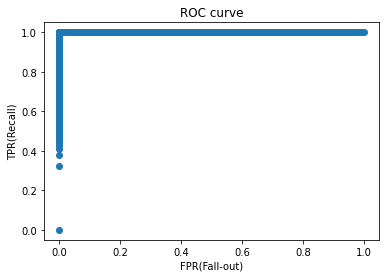

In [163]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

train_score = xgb.score(x_train,y_train)
test_score = xgb.score(x_test,y_test)

y_pred = xgb.predict(x_test)
y_pred_proba_test = xgb.predict_proba(x_test)[:,1]
acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
final_model_report = classification_report(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 시각화
plt.scatter(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("FPR(Fall-out)")
plt.ylabel("TPR(Recall)");

In [164]:
# AUC score 구하기
auc_score = roc_auc_score(y_test, y_pred_proba_test)
print('AUC score:', auc_score)

AUC score: 0.9999874723868944


<br/></br>

### 3-5) feature들의 중요도 비교

deposit_type                      0.499177
required_car_parking_spaces       0.086810
previous_cancellations            0.073213
Room                              0.053482
market_segment                    0.044443
total_of_special_requests         0.041688
country                           0.030542
agent                             0.020594
previous_bookings_not_canceled    0.020524
arrival_date_week_number          0.017150
customer_type                     0.015949
arrival_date_day_of_month         0.012834
reservation_month                 0.012590
arrival_date_year                 0.011273
reservation_day                   0.007601
lead_time                         0.007515
arrival_date_month                0.006688
reservation_year                  0.006444
total_staying_nights              0.006104
adults                            0.004706
days_in_waiting_list              0.003455
stays_in_weekend_nights           0.003007
stays_in_week_nights              0.002788
is_repeated

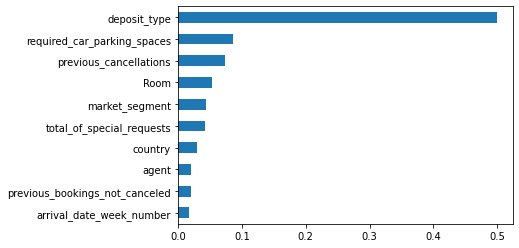

In [165]:
feature_impt = pd.Series(xgb.feature_importances_, feature_names).sort_values(ascending=False)

print(feature_impt)

# 상위 10개 시각화
feature_impt.sort_values(ascending=True)[-10:].plot.barh();

<br/></br>

### 3-6) 특정 feature PDP 구하기

In [166]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 500)
)
model.fit(x_train,y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(max_depth=5, n_estimators=500))])

#### deposit_type

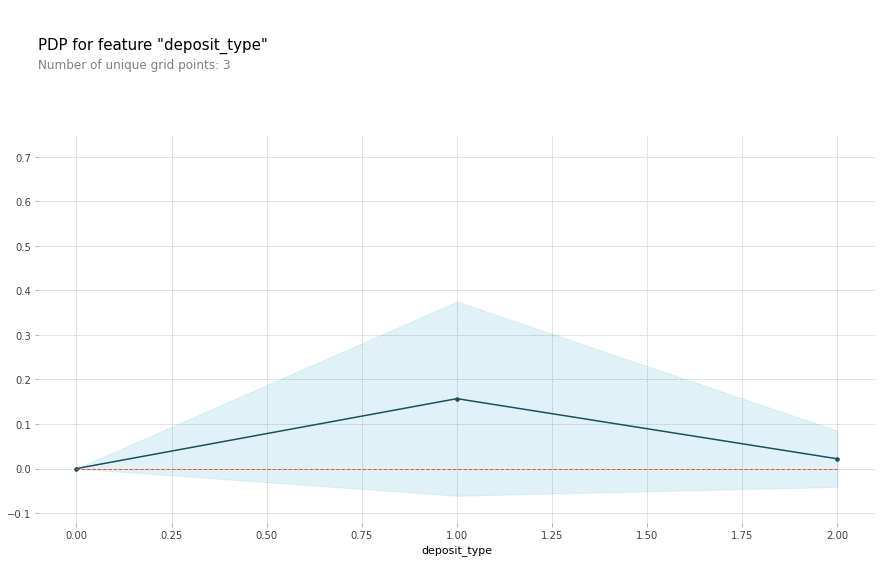

In [167]:
feature = 'deposit_type'
features = feature_names
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

#### required_car_parking_spaces

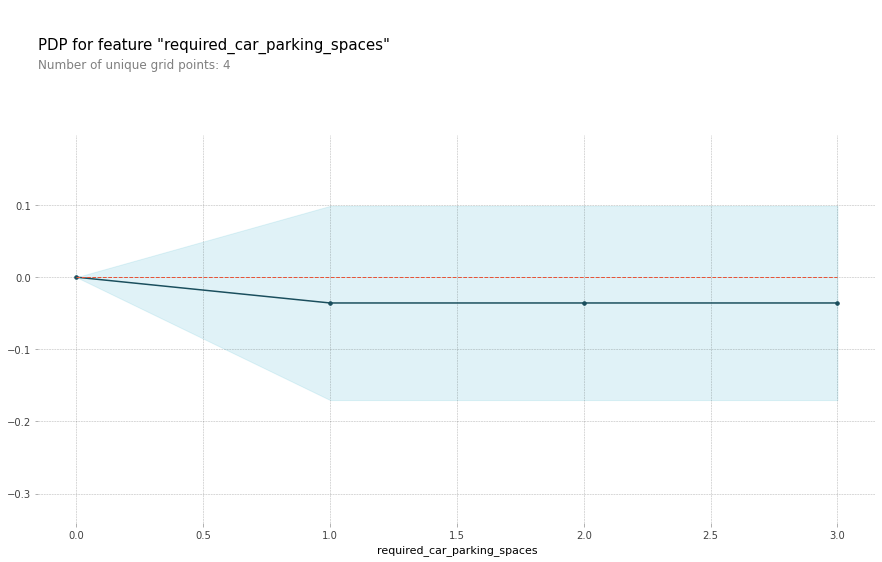

In [168]:
feature = 'required_car_parking_spaces'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train, model_features=features, feature=feature, num_grid_points=10000)
pdp.pdp_plot(pdp_dist, feature);

#### previous_cancellations

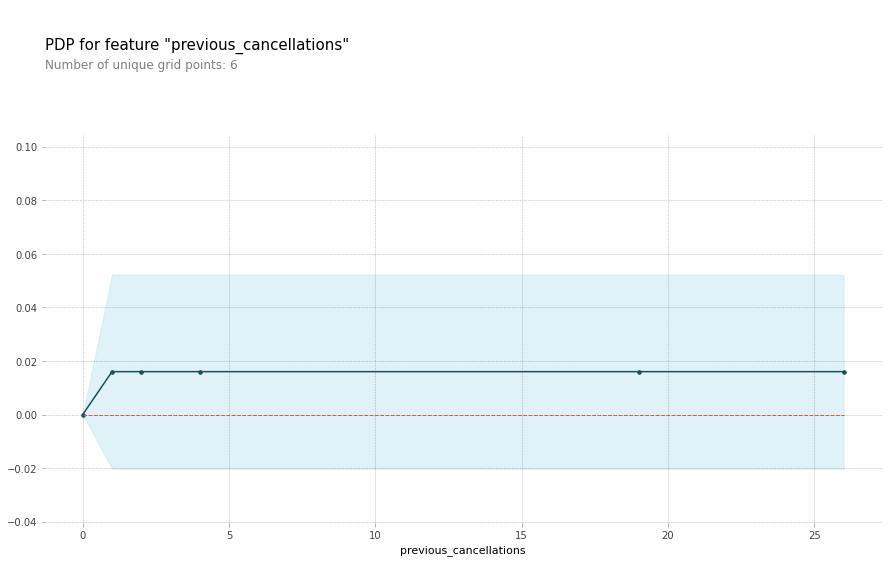

In [169]:
feature = 'previous_cancellations'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train, model_features=features, feature=feature, num_grid_points=1000)
pdp.pdp_plot(pdp_dist, feature);